In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import joblib
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
pd.set_option('display.max_columns', None)

In [83]:
# Crear carpeta para modelos
os.makedirs('models', exist_ok=True)

In [84]:
# Cargar datos
print("📂 Cargando datos...")
df = pd.read_csv('data/df_merge_gpa_complete.csv')
print(f"Shape original: {df.shape}")

📂 Cargando datos...
Shape original: (362701, 168)


In [85]:
# Crear variable objetivo: 1 si reprobó (RP o PF), 0 si aprobó (AP)
print("\n🎯 Creando variable objetivo...")
df['REPROBO'] = df['ESTADO_MAT_TOMADA_MO'].apply(lambda x: 1 if x in ['RP', 'PF'] else 0)
print(f"Distribución de la variable objetivo:")
print(df['REPROBO'].value_counts())
print(f"Porcentaje de reprobados: {df['REPROBO'].mean()*100:.2f}%")


🎯 Creando variable objetivo...
Distribución de la variable objetivo:
REPROBO
0    322307
1     40394
Name: count, dtype: int64
Porcentaje de reprobados: 11.14%


In [86]:
# Seleccionar features relevantes
features_numericas = [
    'VEZ_TOMADA_MO', 'NOTA1_MO', 'NOTA2MO', 'DIFICULTAD_MO',
    'T_MAT_TOMADAS', 'PROM_1PARCIAL', 'PROM_2PARCIAL', 'PROM_CALIFICACIONES',
    'MAT_APROBADAS', 'PROM_CALIF_APROBADAS', 'TERMINOS_REGISTRADOS',
    'PROM_MAT_REPROBADAS1', 'PROM_MAT_REPROBADAS2', 'PROM_MAT_REPROBADAS3',
    'MUY_FACIL', 'FACIL', 'MODERADA', 'DIFICIL', 'MUY_DIFICIL', 'promedio_general',
    'PORCENTAJEDISCAPACIDAD', 'ALIMENTACION_RUBRO', 'TRANSPORTE_RUBRO',
    'VECESBUSENTRADA', 'VECESBUSSALIDA', 'CANTIDADCUARTOS', 'CANTIDADBANIO', 'edad', "GPA"
]

features_categoricas = [
    'TIPOCOLEGIO', 'CATEGORIACOLEGIO', 'BECACOLEGIO', 'COD_MATERIA_ACAD_MO',
    'TIENEDISCAPACIDAD', 'TIPODISCAPACIDAD', 'ESTADOCIVIL', 'OTROSIDIOMAS',
    'IDIOMAS', 'NIVELINGLES', 'TIEMPOPROMEDIOLLEGARESPOL',
    'POSEETARJETACREDITO', 'POSEETARJETADEBITO',
    'NIVELINSTRUCCIONPADRE', 'NIVELINSTRUCCIONMADRE', 'ESTADOCIVILPADRES',
    'FAMILIARDISCAPACIDAD', 'FAMILIARENFERMEDAD', 'TIPOPARROQUIA',
    'VIVEGRUPOFAMILIAR', 'SEXO', "PERDIO_CARRERA", 'termino'
]

# Filtrar features que existen en el dataframe
features_numericas = [f for f in features_numericas if f in df.columns]
features_categoricas = [f for f in features_categoricas if f in df.columns]

print(f"\n📊 Features seleccionadas:")
print(f"  - Numéricas: {len(features_numericas)}")
print(f"  - Categóricas: {len(features_categoricas)}")


📊 Features seleccionadas:
  - Numéricas: 29
  - Categóricas: 23


In [87]:
# Crear copia del dataframe con features seleccionadas
all_features = features_numericas + features_categoricas + ['anio', 'REPROBO']
df_model = df[all_features].copy()

In [88]:
# df_model[((df_model["anio"] == 2025) & (df_model["termino"] == "2S"))]
# df_model = df_model.dropna(subset=['PROM_1PARCIAL', 'PROM_2PARCIAL', 'PROM_CALIFICACIONES'])

In [89]:
# Eliminar filas con valores nulos en features numéricas críticas
print(f"\n🧹 Limpiando datos...")
print(f"Registros antes de limpieza: {len(df_model)}")

# REVISAR HAY MUCHOS NULOS
# df_model = df_model.dropna(subset=['PROM_1PARCIAL', 'PROM_2PARCIAL', 'PROM_CALIFICACIONES']) # no porque 2025 2S tambien tiene null
df_model = df_model.dropna(subset=['anio', 'termino'])
print(f"Registros después de limpieza: {len(df_model)}")


🧹 Limpiando datos...
Registros antes de limpieza: 362701
Registros después de limpieza: 362701


In [90]:
# df_model["DIFICULTAD_MO"] = df_model["DIFICULTAD_MO"].str.replace(',', '.').astype(float).round(2)
# df_model["PROM_CALIFICACIONES"] = df_model["PROM_CALIFICACIONES"].str.replace(',', '.').astype(float).round(2)

In [91]:
# Rellenar valores nulos en features numéricas con la mediana
# no se incluye categorica ni ['anio', 'REPROBO'] ya que son numericas sin nulo
for col in features_numericas:
    if df_model[col].isnull().sum() > 0:
        print(col)
        if df_model[col].dtype == 'O':
            print(col, df_model[col].dtype)
            df_model[col] = df_model[col].str.replace(',', '.').astype(float).round(2)
        df_model[col].fillna(df_model[col].median(), inplace=True)

# Rellenar valores nulos en features categóricas con 'DESCONOCIDO'
for col in features_categoricas:
    if df_model[col].isnull().sum() > 0:
        df_model[col].fillna('DESCONOCIDO', inplace=True)

T_MAT_TOMADAS
PROM_1PARCIAL
PROM_2PARCIAL
PROM_CALIFICACIONES
MAT_APROBADAS
PROM_CALIF_APROBADAS
PROM_MAT_REPROBADAS1
PROM_MAT_REPROBADAS1 object
PROM_MAT_REPROBADAS2
PROM_MAT_REPROBADAS2 object
PROM_MAT_REPROBADAS3
PROM_MAT_REPROBADAS3 object
promedio_general
PORCENTAJEDISCAPACIDAD
edad
GPA


In [92]:
# Aplicar Label Encoding a variables categóricas
print(f"\n🔄 Aplicando Label Encoding...")
label_encoders = {}

for col in features_categoricas:
    le = LabelEncoder()
    df_model[col + '_encoded'] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le
    print(f"  ✓ {col}: {len(le.classes_)} categorías únicas")

# Guardar label encoders
joblib.dump(label_encoders, 'models/label_encoders.pkl')
print(f"\n💾 Label encoders guardados en 'models/label_encoders.pkl'")

# Preparar features finales (numéricas + categóricas encoded)
features_encoded = [col + '_encoded' for col in features_categoricas]
X_columns = features_numericas + features_encoded


🔄 Aplicando Label Encoding...
  ✓ TIPOCOLEGIO: 8 categorías únicas
  ✓ CATEGORIACOLEGIO: 9 categorías únicas
  ✓ BECACOLEGIO: 29 categorías únicas
  ✓ COD_MATERIA_ACAD_MO: 689 categorías únicas
  ✓ TIENEDISCAPACIDAD: 2 categorías únicas
  ✓ TIPODISCAPACIDAD: 7 categorías únicas
  ✓ ESTADOCIVIL: 6 categorías únicas
  ✓ OTROSIDIOMAS: 2 categorías únicas
  ✓ IDIOMAS: 21 categorías únicas
  ✓ NIVELINGLES: 5 categorías únicas
  ✓ TIEMPOPROMEDIOLLEGARESPOL: 6 categorías únicas
  ✓ POSEETARJETACREDITO: 2 categorías únicas
  ✓ POSEETARJETADEBITO: 3 categorías únicas
  ✓ NIVELINSTRUCCIONPADRE: 13 categorías únicas
  ✓ NIVELINSTRUCCIONMADRE: 13 categorías únicas
  ✓ ESTADOCIVILPADRES: 7 categorías únicas
  ✓ FAMILIARDISCAPACIDAD: 722 categorías únicas
  ✓ FAMILIARENFERMEDAD: 414 categorías únicas
  ✓ TIPOPARROQUIA: 2 categorías únicas
  ✓ VIVEGRUPOFAMILIAR: 3 categorías únicas
  ✓ SEXO: 2 categorías únicas
  ✓ PERDIO_CARRERA: 2 categorías únicas
  ✓ termino: 2 categorías únicas

💾 Label encoder

In [93]:
# Separar datos según criterios
print(f"\n{'='*80}")
print(f"📊 SEPARACIÓN DE DATOS")
print(f"{'='*80}")


📊 SEPARACIÓN DE DATOS


In [94]:
anio_objetivo = 2025
termino_objetivo = "2S"

In [95]:
# 1. Datos de inferencia futura: 2025-2S (NO SE USAN EN ENTRENAMIENTO)
mask_inferencia = (df_model['anio'] == anio_objetivo) & (df_model['termino'] == termino_objetivo)
df_inferencia = df_model[mask_inferencia].copy()
df_rest = df_model[~mask_inferencia].copy()

print(f"\n🔮 DATOS PARA INFERENCIA FUTURA (2025-2S):")
print(f"  - Total registros: {len(df_inferencia)}")
if len(df_inferencia) > 0:
    print(f"  - Distribución: {df_inferencia['REPROBO'].value_counts().to_dict()}")
    # Guardar datos de inferencia
    df_inferencia.to_csv('models/datos_inferencia_2025_2S.csv', index=False)
    print(f"  💾 Guardados en 'models/datos_inferencia_2025_2S.csv'")
else:
    print(f"  ⚠️ No hay datos disponibles para 2025-2S")


🔮 DATOS PARA INFERENCIA FUTURA (2025-2S):
  - Total registros: 30340
  - Distribución: {0: 30340}
  💾 Guardados en 'models/datos_inferencia_2025_2S.csv'


In [96]:
df_model.head()

,VEZ_TOMADA_MO,NOTA1_MO,NOTA2MO,DIFICULTAD_MO,T_MAT_TOMADAS,PROM_1PARCIAL,PROM_2PARCIAL,PROM_CALIFICACIONES,MAT_APROBADAS,PROM_CALIF_APROBADAS,TERMINOS_REGISTRADOS,PROM_MAT_REPROBADAS1,PROM_MAT_REPROBADAS2,PROM_MAT_REPROBADAS3,MUY_FACIL,FACIL,MODERADA,DIFICIL,MUY_DIFICIL,promedio_general,PORCENTAJEDISCAPACIDAD,ALIMENTACION_RUBRO,TRANSPORTE_RUBRO,VECESBUSENTRADA,VECESBUSSALIDA,CANTIDADCUARTOS,CANTIDADBANIO,edad,GPA,TIPOCOLEGIO,CATEGORIACOLEGIO,BECACOLEGIO,COD_MATERIA_ACAD_MO,TIENEDISCAPACIDAD,TIPODISCAPACIDAD,ESTADOCIVIL,OTROSIDIOMAS,IDIOMAS,NIVELINGLES,TIEMPOPROMEDIOLLEGARESPOL,POSEETARJETACREDITO,POSEETARJETADEBITO,NIVELINSTRUCCIONPADRE,NIVELINSTRUCCIONMADRE,ESTADOCIVILPADRES,FAMILIARDISCAPACIDAD,FAMILIARENFERMEDAD,TIPOPARROQUIA,VIVEGRUPOFAMILIAR,SEXO,PERDIO_CARRERA,termino,anio,REPROBO,TIPOCOLEGIO_encoded,CATEGORIACOLEGIO_encoded,BECACOLEGIO_encoded,COD_MATERIA_ACAD_MO_encoded,TIENEDISCAPACIDAD_encoded,TIPODISCAPACIDAD_encoded,ESTADOCIVIL_encoded,OTROSIDIOMAS_encoded,IDIOMAS_encoded,NIVELINGLES_encoded,TIEMPOPROMEDIOLLEGARESPOL_encoded,POSEETARJETACREDITO_encoded,POSEETARJETADEBITO_encoded,NIVELINSTRUCCIONPADRE_encoded,NIVELINSTRUCCIONMADRE_encoded,ESTADOCIVILPADRES_encoded,FAMILIARDISCAPACIDAD_encoded,FAMILIARENFERMEDAD_encoded,TIPOPARROQUIA_encoded,VIVEGRUPOFAMILIAR_encoded,SEXO_encoded,PERDIO_CARRERA_encoded,termino_encoded
0,1,87,93,7.9,53.0,5.9,6.4,6.83,47.0,7.06,17.0,5.14,4.25,5.35,0,0,2,1,0,7.55,0.0,100.000000,20.000000,1,0,2,1,32.0,6.72,Particular,0.0,Excelencia académica,ACUG1035,N,no definida,casado,SI,INGLÉS,NINGUNO,61 a 90 minutos,SI,No,Superior Universitaria completa,Superior no Universitaria (tecnología o técnic...,Casados,No,No,URBANA,SI,Masculino,N,1S,2020,0,7,0,4,0,0,4,1,1,13,3,3,1,1,9,12,0,297,173,1,2,1,0,0
1,1,85,89,7.9,59.0,6.1,7.4,7.48,51.0,7.94,14.0,4.16,5.20,5.15,0,0,2,1,0,7.55,0.0,42.857143,11.428571,3,2,3,2,30.0,7.18,Fiscal,1.0,Ninguna,ACUG1035,N,Ninguna,soltero,NO,NINGUNO,NINGUNO,31 a 60 minutos,NO,SI,Secundaria Completa,Secundaria Incompleta,Casados,No,No,URBANA,SI,Femenino,S,1S,2020,0,1,1,17,0,0,0,3,0,17,3,2,0,2,6,7,0,297,173,1,2,0,1,0
2,1,86,89,7.9,59.0,5.6,6.7,6.97,50.0,7.45,13.0,4.27,4.30,4.80,0,1,1,0,1,7.55,0.0,50.000000,25.000000,2,2,2,2,31.0,6.74,Fiscal,1.0,Ninguna,ACUG1035,N,Ninguna,soltero,SI,INGLÉS,NINGUNO,91 a 120 minutos,SI,No,DESCONOCIDO,DESCONOCIDO,Viudo/a,No,No,RURAL,SI,Masculino,S,1S,2020,0,1,1,17,0,0,0,3,1,13,3,4,1,1,0,0,6,297,173,0,2,1,1,0
3,1,83,93,7.9,49.0,6.5,7.4,7.73,47.0,7.93,11.0,3.01,4.93,4.77,0,0,2,2,0,7.55,0.0,166.666667,16.666667,3,3,3,2,28.0,7.39,Particular,0.0,Ninguna,ACUG1035,N,Ninguna,soltero,SI,INGLÉS,NINGUNO,31 a 60 minutos,NO,SI,DESCONOCIDO,Secundaria Completa,Viudo/a,No,No,URBANA,SI,Masculino,N,1S,2020,0,7,0,17,0,0,0,3,1,13,3,2,0,2,0,6,6,297,173,1,2,1,0,0
4,1,95,95,7.9,39.0,7.2,7.7,8.02,39.0,8.02,8.0,4.66,4.93,4.77,0,1,1,1,0,7.55,0.0,50.000000,40.000000,0,0,5,5,27.0,7.93,Particular,10.0,Ninguna,ACUG1035,N,Ninguna,soltero,SI,INGLÉS,NINGUNO,16 a 30 minutos,NO,SI,Superior Universitaria completa,Superior Universitaria completa,Casados,No,No,URBANA,SI,Masculino,N,1S,2020,0,7,2,17,0,0,0,3,1,13,3,1,0,2,9,9,0,297,173,1,2,1,0,0


In [97]:
anio_test = 2025
termino_test = "1S"

In [98]:
# 2. Datos de test: 2025-1S
mask_test = (df_rest['anio'] == anio_test) & (df_rest['termino'] == termino_test)
df_test = df_rest[mask_test].copy()
df_rest_2 = df_rest[~mask_test].copy()

print(f"\n🧪 DATOS DE TEST (2025-1S):")
print(f"  - Total registros: {len(df_test)}")
if len(df_test) > 0:
    print(f"  - Distribución: {df_test['REPROBO'].value_counts().to_dict()}")
    X_test = df_test[X_columns]
    y_test = df_test['REPROBO']
else:
    print(f"  ⚠️ No hay datos disponibles para 2025-1S")
    X_test, y_test = None, None


🧪 DATOS DE TEST (2025-1S):
  - Total registros: 28650
  - Distribución: {0: 25420, 1: 3230}


In [99]:
# 3. Datos de entrenamiento y validación: 2020-2024 (el resto de semestres)
df_train_val = df_rest_2.copy()
print(f"\n📚 DATOS DE TRAIN + VAL (2020-2024, todos los semestres):")
print(f"  - Total registros: {len(df_train_val)}")
print(f"  - Distribución por año:")
for year in sorted(df_train_val['anio'].unique()):
    count = len(df_train_val[df_train_val['anio'] == year])
    print(f"    • {year}: {count} registros")


📚 DATOS DE TRAIN + VAL (2020-2024, todos los semestres):
  - Total registros: 303711
  - Distribución por año:
    • 2020: 85321 registros
    • 2021: 56178 registros
    • 2022: 54734 registros
    • 2023: 53599 registros
    • 2024: 53879 registros


In [100]:
# Split train/val (80/20) 
X_train_val = df_train_val[X_columns]
y_train_val = df_train_val['REPROBO']

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train_val
)

In [101]:
list_years = sorted(df_train_val["anio"].unique().tolist())
print(f"\n📈 DISTRIBUCIÓN FINAL DE DATOS:")
print(f"  ✓ TRAIN (80% de {list_years[0]}-{list_years[-1]}): {len(X_train)} registros")
print(f"    - Aprobados: {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"    - Reprobados: {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"\n  ✓ VAL (20% de {list_years[0]}-{list_years[-1]}): {len(X_val)} registros")
print(f"    - Aprobados: {(y_val == 0).sum()} ({(y_val == 0).sum()/len(y_val)*100:.2f}%)")
print(f"    - Reprobados: {(y_val == 1).sum()} ({(y_val == 1).sum()/len(y_val)*100:.2f}%)")

if X_test is not None:
    print(f"\n  ✓ TEST ({anio_test}-{termino_test}): {len(X_test)} registros")
    print(f"    - Aprobados: {(y_test == 0).sum()} ({(y_test == 0).sum()/len(y_test)*100:.2f}%)")
    print(f"    - Reprobados: {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test)*100:.2f}%)")

if len(df_inferencia) > 0:
    print(f"\n  🔮 INFERENCIA ({anio_objetivo}-{termino_objetivo}): {len(df_inferencia)} registros")
    print(f"    - (Datos guardados para inferencia futura)")

# Guardar información de features
feature_info = {
    'features_numericas': features_numericas,
    'features_categoricas': features_categoricas,
    'X_columns': X_columns,
    'target': 'REPROBO'
}
joblib.dump(feature_info, 'models/feature_info.pkl')
print(f"\n💾 Información de features guardada en 'models/feature_info.pkl'")


📈 DISTRIBUCIÓN FINAL DE DATOS:
  ✓ TRAIN (80% de 2020-2024): 242968 registros
    - Aprobados: 213237 (87.76%)
    - Reprobados: 29731 (12.24%)

  ✓ VAL (20% de 2020-2024): 60743 registros
    - Aprobados: 53310 (87.76%)
    - Reprobados: 7433 (12.24%)

  ✓ TEST (2025-1S): 28650 registros
    - Aprobados: 25420 (88.73%)
    - Reprobados: 3230 (11.27%)

  🔮 INFERENCIA (2025-2S): 30340 registros
    - (Datos guardados para inferencia futura)

💾 Información de features guardada en 'models/feature_info.pkl'



📈 Distribución final de datos:
  - Train: 236021 registros
  - Test: 59006 registros
  - Validación: 25790 registros

💾 Información de features guardada en 'models/feature_info.pkl'

Matriz de confusion

In [102]:
# Función para entrenar y evaluar modelos
def entrenar_evaluar_modelo(nombre, modelo, X_train, y_train, X_val, y_val, X_test=None, y_test=None):
    print(f"\n{'='*80}")
    print(f"🤖 Entrenando {nombre}...")
    print(f"{'='*80}")
    
    # Entrenar
    modelo.fit(X_train, y_train)
    
    # Predicciones en train
    y_train_pred = modelo.predict(X_train)
    y_train_proba = modelo.predict_proba(X_train)[:, 1] if hasattr(modelo, 'predict_proba') else None
    
    # Predicciones en validación
    y_val_pred = modelo.predict(X_val)
    y_val_proba = modelo.predict_proba(X_val)[:, 1] if hasattr(modelo, 'predict_proba') else None
    
    # Métricas Train
    print(f"\n📊 MÉTRICAS EN TRAIN (80% de 2020-2024):")
    print(f"  Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    if y_train_proba is not None:
        print(f"  ROC-AUC: {roc_auc_score(y_train, y_train_proba):.4f}")
    
    # Métricas Validación
    print(f"\n📊 MÉTRICAS EN VALIDACIÓN (20% de 2020-2024):")
    print(f"  Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
    if y_val_proba is not None:
        print(f"  ROC-AUC: {roc_auc_score(y_val, y_val_proba):.4f}")
    print(f"\n  Classification Report:")
    print(classification_report(y_val, y_val_pred, target_names=['Aprobado', 'Reprobado']))
    
    # Métricas Test (2025-1S)
    if X_test is not None and y_test is not None:
        y_test_pred = modelo.predict(X_test)
        y_test_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, 'predict_proba') else None
        
        print(f"\n📊 MÉTRICAS EN TEST (2025-1S):")
        print(f"  Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
        if y_test_proba is not None:
            print(f"  ROC-AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
        print(f"\n  Classification Report:")
        print(classification_report(y_test, y_test_pred, target_names=['Aprobado', 'Reprobado']))
        
        # Matriz de confusión
        cm = confusion_matrix(y_test, y_test_pred)
        print(f"\n  Matriz de Confusión:")
        print(f"    [[TN={cm[0,0]}, FP={cm[0,1]}],")
        print(f"     [FN={cm[1,0]}, TP={cm[1,1]}]]")
    
    return modelo


In [103]:
def evaluar_modelo_completo(modelo, X, y, nombre_conjunto='Conjunto', 
                           mostrar_graficos=True, guardar_graficos=False, 
                           ruta_guardado='models/'):
    """
    Función completa para evaluar un modelo de clasificación binaria.
    
    Parámetros:
    -----------
    modelo : objeto modelo entrenado
        Modelo de sklearn/xgboost con métodos predict y predict_proba
    X : array-like o DataFrame
        Features del conjunto a evaluar
    y : array-like o Series
        Etiquetas reales del conjunto
    nombre_conjunto : str, default='Conjunto'
        Nombre descriptivo del conjunto (ej: 'Validación', 'Test', etc.)
    mostrar_graficos : bool, default=True
        Si True, muestra gráficos de matriz de confusión y curva ROC
    guardar_graficos : bool, default=False
        Si True, guarda los gráficos en la ruta especificada
    ruta_guardado : str, default='models/'
        Ruta donde guardar los gráficos
    
    Retorna:
    --------
    dict : Diccionario con todas las métricas y predicciones
        {
            'predicciones': array de predicciones,
            'probabilidades': array de probabilidades,
            'matriz_confusion': matriz de confusión,
            'accuracy': exactitud,
            'precision': precisión,
            'recall': sensibilidad,
            'f1_score': f1-score,
            'roc_auc': área bajo la curva ROC,
            'classification_report': reporte de clasificación
        }
    """
    
    print(f"\n{'='*80}")
    print(f"📊 EVALUACIÓN DEL MODELO EN {nombre_conjunto.upper()}")
    print(f"{'='*80}")
    
    # Realizar predicciones
    y_pred = modelo.predict(X)
    
    # Obtener probabilidades si el modelo lo soporta
    if hasattr(modelo, 'predict_proba'):
        y_proba = modelo.predict_proba(X)[:, 1]
    else:
        y_proba = None
        print("⚠️ El modelo no soporta predict_proba, algunas métricas no estarán disponibles")
    
    # Calcular matriz de confusión
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calcular métricas
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    
    # ROC-AUC solo si tenemos probabilidades
    roc_auc = roc_auc_score(y, y_proba) if y_proba is not None else None
    
    # Imprimir resultados
    print(f"\n📈 MÉTRICAS GENERALES:")
    print(f"  • Accuracy (Exactitud):     {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  • Precision (Precisión):    {precision:.4f} ({precision*100:.2f}%)")
    print(f"  • Recall (Sensibilidad):    {recall:.4f} ({recall*100:.2f}%)")
    print(f"  • F1-Score:                 {f1:.4f}")
    if roc_auc is not None:
        print(f"  • ROC-AUC:                  {roc_auc:.4f}")
    
    print(f"\n📊 MATRIZ DE CONFUSIÓN:")
    print(f"  ┌─────────────────────────────────────┐")
    print(f"  │           Predicción                │")
    print(f"  │         Aprobará  │  Reprobará      │")
    print(f"  ├─────────────────────────────────────┤")
    print(f"  │ Real    │         │                 │")
    print(f"  │ Aprobó  │  {tn:6d}   │   {fp:6d}        │  TN / FP")
    print(f"  │ Reprobó │  {fn:6d}   │   {tp:6d}        │  FN / TP")
    print(f"  └─────────────────────────────────────┘")
    
    print(f"\n📋 INTERPRETACIÓN:")
    print(f"  • Verdaderos Negativos (TN): {tn:,} - Correctamente predichos como APROBARÁ")
    print(f"  • Falsos Positivos (FP):     {fp:,} - Incorrectamente predichos como REPROBARÁ")
    print(f"  • Falsos Negativos (FN):     {fn:,} - Incorrectamente predichos como APROBARÁ")
    print(f"  • Verdaderos Positivos (TP): {tp:,} - Correctamente predichos como REPROBARÁ")
    
    # Métricas adicionales
    total = len(y)
    tasa_aprobados_real = (y == 0).sum() / total
    tasa_reprobados_real = (y == 1).sum() / total
    tasa_aprobados_pred = (y_pred == 0).sum() / total
    tasa_reprobados_pred = (y_pred == 1).sum() / total
    
    print(f"\n📊 DISTRIBUCIÓN:")
    print(f"  Real:")
    print(f"    - Aprobados:  {(y == 0).sum():,} ({tasa_aprobados_real*100:.2f}%)")
    print(f"    - Reprobados: {(y == 1).sum():,} ({tasa_reprobados_real*100:.2f}%)")
    print(f"  Predicho:")
    print(f"    - Aprobados:  {(y_pred == 0).sum():,} ({tasa_aprobados_pred*100:.2f}%)")
    print(f"    - Reprobados: {(y_pred == 1).sum():,} ({tasa_reprobados_pred*100:.2f}%)")
    
    # Classification Report
    print(f"\n📋 CLASSIFICATION REPORT:")
    print(classification_report(y, y_pred, target_names=['Aprobado', 'Reprobado'], digits=4))
    
    # Análisis de probabilidades si están disponibles
    if y_proba is not None:
        print(f"\n📊 ANÁLISIS DE PROBABILIDADES:")
        print(f"  • Probabilidad promedio de reprobar: {y_proba.mean():.4f}")
        print(f"  • Probabilidad mínima: {y_proba.min():.4f}")
        print(f"  • Probabilidad máxima: {y_proba.max():.4f}")
        print(f"  • Desviación estándar: {y_proba.std():.4f}")
        
        # Estudiantes por nivel de riesgo
        alto_riesgo = (y_proba > 0.7).sum()
        riesgo_moderado = ((y_proba > 0.5) & (y_proba <= 0.7)).sum()
        riesgo_bajo = ((y_proba > 0.3) & (y_proba <= 0.5)).sum()
        sin_riesgo = (y_proba <= 0.3).sum()
        
        print(f"\n⚠️ NIVELES DE RIESGO:")
        print(f"  • Alto riesgo (prob > 0.7):        {alto_riesgo:,} ({alto_riesgo/total*100:.2f}%)")
        print(f"  • Riesgo moderado (0.5 < p ≤ 0.7): {riesgo_moderado:,} ({riesgo_moderado/total*100:.2f}%)")
        print(f"  • Riesgo bajo (0.3 < p ≤ 0.5):     {riesgo_bajo:,} ({riesgo_bajo/total*100:.2f}%)")
        print(f"  • Sin riesgo (prob ≤ 0.3):         {sin_riesgo:,} ({sin_riesgo/total*100:.2f}%)")
    
    # Crear gráficos
    if mostrar_graficos or guardar_graficos:
        fig, axes = plt.subplots(1, 2 if y_proba is not None else 1, figsize=(15, 5))
        
        if y_proba is not None:
            ax1, ax2 = axes
        else:
            ax1 = axes
        
        # Gráfico 1: Matriz de Confusión
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Aprobará', 'Reprobará'],
                    yticklabels=['Aprobó', 'Reprobó'],
                    ax=ax1, cbar_kws={'label': 'Cantidad'})
        ax1.set_title(f'Matriz de Confusión - {nombre_conjunto}', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Valor Real', fontsize=12)
        ax1.set_xlabel('Predicción', fontsize=12)
        
        # Agregar porcentajes
        for i in range(2):
            for j in range(2):
                percentage = cm[i, j] / cm.sum() * 100
                ax1.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                        ha='center', va='center', fontsize=10, color='gray')
        
        # Gráfico 2: Curva ROC (si hay probabilidades)
        if y_proba is not None:
            fpr, tpr, thresholds = roc_curve(y, y_proba)
            ax2.plot(fpr, tpr, color='darkorange', lw=2, 
                    label=f'ROC curve (AUC = {roc_auc:.4f})')
            ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
            ax2.set_xlim([0.0, 1.0])
            ax2.set_ylim([0.0, 1.05])
            ax2.set_xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
            ax2.set_ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
            ax2.set_title(f'Curva ROC - {nombre_conjunto}', fontsize=14, fontweight='bold')
            ax2.legend(loc="lower right")
            ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        
        if guardar_graficos:
            import os
            os.makedirs(ruta_guardado, exist_ok=True)
            nombre_archivo = f"{ruta_guardado}evaluacion_{nombre_conjunto.lower().replace(' ', '_')}.png"
            plt.savefig(nombre_archivo, dpi=300, bbox_inches='tight')
            print(f"\n💾 Gráficos guardados en '{nombre_archivo}'")
        
        if mostrar_graficos:
            plt.show()
        else:
            plt.close()
    
    # Preparar diccionario de resultados
    resultados = {
        'predicciones': y_pred,
        'probabilidades': y_proba,
        'matriz_confusion': cm,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'classification_report': classification_report(y, y_pred, 
                                                       target_names=['Aprobado', 'Reprobado'],
                                                       output_dict=True)
    }
    
    print(f"\n{'='*80}")
    print(f"✅ EVALUACIÓN COMPLETADA")
    print(f"{'='*80}\n")
    
    return resultados

In [104]:
# 1. Random Forest
print(f"\n{'#'*80}")
print(f"# MODELO 1: RANDOM FOREST")
print(f"{'#'*80}")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model = entrenar_evaluar_modelo('Random Forest', rf_model, X_train, y_train, X_val, y_val, X_test, y_test)
joblib.dump(rf_model, 'models/random_forest_model.pkl')
print(f"\n💾 Modelo guardado en 'models/random_forest_model.pkl'")


################################################################################
# MODELO 1: RANDOM FOREST
################################################################################

🤖 Entrenando Random Forest...

📊 MÉTRICAS EN TRAIN (80% de 2020-2024):
  Accuracy: 0.9511
  ROC-AUC: 0.9923

📊 MÉTRICAS EN VALIDACIÓN (20% de 2020-2024):
  Accuracy: 0.9376
  ROC-AUC: 0.9802

  Classification Report:
              precision    recall  f1-score   support

    Aprobado       0.99      0.94      0.96     53310
   Reprobado       0.69      0.91      0.78      7433

    accuracy                           0.94     60743
   macro avg       0.84      0.92      0.87     60743
weighted avg       0.95      0.94      0.94     60743


📊 MÉTRICAS EN TEST (2025-1S):
  Accuracy: 0.9308
  ROC-AUC: 0.9781

  Classification Report:
              precision    recall  f1-score   support

    Aprobado       0.99      0.93      0.96     25420
   Reprobado       0.64      0.91      0.75      3230

    accu


📊 EVALUACIÓN DEL MODELO EN VALIDACIÓN

📈 MÉTRICAS GENERALES:
  • Accuracy (Exactitud):     0.9376 (93.76%)
  • Precision (Precisión):    0.6851 (68.51%)
  • Recall (Sensibilidad):    0.9068 (90.68%)
  • F1-Score:                 0.7805
  • ROC-AUC:                  0.9802

📊 MATRIZ DE CONFUSIÓN:
  ┌─────────────────────────────────────┐
  │           Predicción                │
  │         Aprobará  │  Reprobará      │
  ├─────────────────────────────────────┤
  │ Real    │         │                 │
  │ Aprobó  │   50212   │     3098        │  TN / FP
  │ Reprobó │     693   │     6740        │  FN / TP
  └─────────────────────────────────────┘

📋 INTERPRETACIÓN:
  • Verdaderos Negativos (TN): 50,212 - Correctamente predichos como APROBARÁ
  • Falsos Positivos (FP):     3,098 - Incorrectamente predichos como REPROBARÁ
  • Falsos Negativos (FN):     693 - Incorrectamente predichos como APROBARÁ
  • Verdaderos Positivos (TP): 6,740 - Correctamente predichos como REPROBARÁ

📊 DISTRIBUC

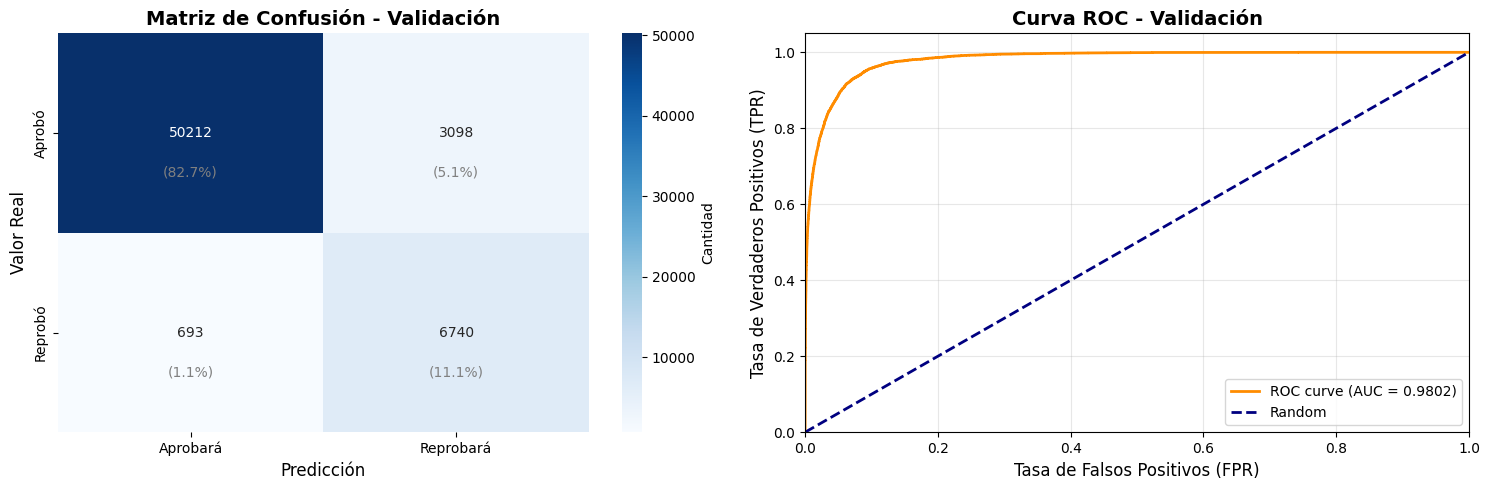


✅ EVALUACIÓN COMPLETADA



In [105]:
resultados_val = evaluar_modelo_completo(
    modelo=rf_model,
    X=X_val,
    y=y_val,
    nombre_conjunto='Validación',
    mostrar_graficos=True,
    guardar_graficos=True,
    ruta_guardado='models/'
)

In [106]:
# # 2. SVM
# print(f"\n{'#'*80}")
# print(f"# MODELO 2: SVM")
# print(f"{'#'*80}")
# svm_model = SVC(
#     kernel='rbf',
#     C=1.0,
#     gamma='scale',
#     probability=True,
#     random_state=42,
#     class_weight='balanced'
# )
# svm_model = entrenar_evaluar_modelo('SVM', svm_model, X_train, y_train, X_val, y_val, X_test, y_test)
# joblib.dump(svm_model, 'models/svm_model.pkl')
# print(f"\n💾 Modelo guardado en 'models/svm_model.pkl'")

In [107]:
# 3. Regresión Logística
print(f"\n{'#'*80}")
print(f"# MODELO 3: REGRESIÓN LOGÍSTICA")
print(f"{'#'*80}")
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    solver='lbfgs'
)
lr_model = entrenar_evaluar_modelo('Regresión Logística', lr_model, X_train, y_train, X_val, y_val, X_test, y_test)
joblib.dump(lr_model, 'models/logistic_regression_model.pkl')
print(f"\n💾 Modelo guardado en 'models/logistic_regression_model.pkl'")


################################################################################
# MODELO 3: REGRESIÓN LOGÍSTICA
################################################################################

🤖 Entrenando Regresión Logística...

📊 MÉTRICAS EN TRAIN (80% de 2020-2024):
  Accuracy: 0.9191
  ROC-AUC: 0.9789

📊 MÉTRICAS EN VALIDACIÓN (20% de 2020-2024):
  Accuracy: 0.9178
  ROC-AUC: 0.9783

  Classification Report:
              precision    recall  f1-score   support

    Aprobado       0.99      0.92      0.95     53310
   Reprobado       0.61      0.93      0.73      7433

    accuracy                           0.92     60743
   macro avg       0.80      0.92      0.84     60743
weighted avg       0.94      0.92      0.92     60743


📊 MÉTRICAS EN TEST (2025-1S):
  Accuracy: 0.9057
  ROC-AUC: 0.8393

  Classification Report:
              precision    recall  f1-score   support

    Aprobado       0.96      0.93      0.95     25420
   Reprobado       0.56      0.71      0.63      32

In [108]:
# 4. XGBoost
print(f"\n{'#'*80}")
print(f"# MODELO 4: XGBOOST")
print(f"{'#'*80}")

# Calcular scale_pos_weight para balancear clases
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss'
)
xgb_model = entrenar_evaluar_modelo('XGBoost', xgb_model, X_train, y_train, X_val, y_val, X_test, y_test)
joblib.dump(xgb_model, 'models/xgboost_model.pkl')
print(f"\n💾 Modelo guardado en 'models/xgboost_model.pkl'")


################################################################################
# MODELO 4: XGBOOST
################################################################################

🤖 Entrenando XGBoost...

📊 MÉTRICAS EN TRAIN (80% de 2020-2024):
  Accuracy: 0.9302
  ROC-AUC: 0.9870

📊 MÉTRICAS EN VALIDACIÓN (20% de 2020-2024):
  Accuracy: 0.9265
  ROC-AUC: 0.9836

  Classification Report:
              precision    recall  f1-score   support

    Aprobado       0.99      0.92      0.96     53310
   Reprobado       0.63      0.95      0.76      7433

    accuracy                           0.93     60743
   macro avg       0.81      0.93      0.86     60743
weighted avg       0.95      0.93      0.93     60743


📊 MÉTRICAS EN TEST (2025-1S):
  Accuracy: 0.9253
  ROC-AUC: 0.9829

  Classification Report:
              precision    recall  f1-score   support

    Aprobado       0.99      0.92      0.96     25420
   Reprobado       0.61      0.94      0.74      3230

    accuracy        

In [109]:
# Resumen final
print(f"\n{'='*80}")
print(f"✅ ENTRENAMIENTO COMPLETADO")
print(f"{'='*80}")
print(f"\n📁 Archivos guardados en la carpeta 'models/':")
print(f"  ✓ label_encoders.pkl - Encoders para variables categóricas")
print(f"  ✓ feature_info.pkl - Información de features")
print(f"  ✓ random_forest_model.pkl - Modelo Random Forest")
print(f"  ✓ svm_model.pkl - Modelo SVM")
print(f"  ✓ logistic_regression_model.pkl - Modelo Regresión Logística")
print(f"  ✓ xgboost_model.pkl - Modelo XGBoost")
if len(df_inferencia) > 0:
    print(f"  ✓ datos_inferencia_2025_2S.csv - Datos para inferencia futura")

print(f"\n📊 RESUMEN DE DATOS:")
print(f"  • Train: 2020-2024 (80%) - {len(X_train)} registros")
print(f"  • Val: 2020-2024 (20%) - {len(X_val)} registros")
if X_test is not None:
    print(f"  • Test: 2025-1S - {len(X_test)} registros")
if len(df_inferencia) > 0:
    print(f"  • Inferencia: 2025-2S - {len(df_inferencia)} registros (guardados para uso futuro)")

print(f"\n🎯 Variable objetivo: REPROBO (1=Reprobado/PF, 0=Aprobado)")
print(f"📊 Total de features: {len(X_columns)}")
print(f"   - Numéricas: {len(features_numericas)}")
print(f"   - Categóricas (encoded): {len(features_encoded)}")


✅ ENTRENAMIENTO COMPLETADO

📁 Archivos guardados en la carpeta 'models/':
  ✓ label_encoders.pkl - Encoders para variables categóricas
  ✓ feature_info.pkl - Información de features
  ✓ random_forest_model.pkl - Modelo Random Forest
  ✓ svm_model.pkl - Modelo SVM
  ✓ logistic_regression_model.pkl - Modelo Regresión Logística
  ✓ xgboost_model.pkl - Modelo XGBoost
  ✓ datos_inferencia_2025_2S.csv - Datos para inferencia futura

📊 RESUMEN DE DATOS:
  • Train: 2020-2024 (80%) - 242968 registros
  • Val: 2020-2024 (20%) - 60743 registros
  • Test: 2025-1S - 28650 registros
  • Inferencia: 2025-2S - 30340 registros (guardados para uso futuro)

🎯 Variable objetivo: REPROBO (1=Reprobado/PF, 0=Aprobado)
📊 Total de features: 52
   - Numéricas: 29
   - Categóricas (encoded): 23
